**NOTE:** before to start this notebook go to edit-> Notebook settings and select GPU as a hardware accelerator. Now your ready to go!

# Part 0: Coding a basic multi-task network

We will begin today's exercises by converting a standard single output network into a multi-task one. Our base network is a simplified version of a ResNet (Residual network), designed to carry out age regression. We will seek to extend it by adding an additional branch that will learn to classify the images according to sex.
<Include image here of network before and after>

In [1]:
%matplotlib inline
import os

# Training and the data

We will be using a large-scale face dataset, [UTKface](https://susanqq.github.io/UTKFace/). It consists of 23705 images of faces with ages ranging between 0 and 116, labelled according to age, sex, and ethnicity. While the dataset contains images of varying poses and zooms, we will only be using a subset of cropped and aligned faces, to make our jobs a little easier.

### Importing the data
The dataset consists of jpeg images, where the labels are contained in the name with the format: __[age]\_[sex]\_[ethnicity]_[date+time].jpg__  
Let's begin by importing the necessary libraries for the notebook and showcasing the functions that will allow you to load in the dataset and extract the labels contained in each image:

In [2]:
file_download_link = "https://github.com/KCL-BMEIS/AdvancedMachineLearningCourse/blob/main/Week4-Multitask_and_domain_shift/Data/UTKFace.zip?raw=true"
!wget -O UTKFace.zip --no-check-certificate "$file_download_link"
!unzip UTKFace.zip

--2021-02-07 17:16:46--  https://github.com/KCL-BMEIS/AdvancedMachineLearningCourse/blob/main/Week4-Multitask_and_domain_shift/Data/UTKFace.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/KCL-BMEIS/AdvancedMachineLearningCourse/raw/main/Week4-Multitask_and_domain_shift/Data/UTKFace.zip [following]
--2021-02-07 17:16:46--  https://github.com/KCL-BMEIS/AdvancedMachineLearningCourse/raw/main/Week4-Multitask_and_domain_shift/Data/UTKFace.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/KCL-BMEIS/AdvancedMachineLearningCourse/main/Week4-Multitask_and_domain_shift/Data/UTKFace.zip [following]
--2021-02-07 17:16:46--  https://raw.githubusercontent.com/KCL-BMEIS/AdvancedMachineLearningCourse/main/Week4-Multitask_and_domain_shift/Data/

# Training and the data

We will be using a large-scale face dataset, [UTKface](https://susanqq.github.io/UTKFace/). It consists of 23705 images of faces with ages ranging between 0 and 116, labelled according to age, sex, and ethnicity. While the dataset contains images of varying poses and zooms, we will only be using a subset of cropped and aligned faces, to make our jobs a little easier.

### Importing the data
The dataset consists of jpeg images, where the labels are contained in the name with the format: __[age]\_[sex]\_[ethnicity]_[date+time].jpg__  
Let's begin by importing the necessary libraries for the notebook and showcasing the functions that will allow you to load in the dataset and extract the labels contained in each image:

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataloader import default_collate
import glob
import matplotlib.pyplot as plt
from PIL import Image

# A list containing common image file extensions for verification purposes
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


# Checks if the passed file is an image
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


# A function to extract each of the relevant labels contained in the filename: We exclude data and time
def extract_labels(filename):
    age, sex, ethnicity = filename.split('_')[:3]
    return age, sex, ethnicity


# A function for creating tuples of filenames and their corresponding labels for loaded in data
def make_dataset(dir):
    images = []
    for filename in glob.glob(os.path.join(dir, '*_*_*_*')):
        if is_image_file(filename):
            filename = os.path.basename(filename)
            age, sex, race = extract_labels(filename)
            item = (filename, [age, sex, race])
            images.append(item)
    return images


# Simple image RGB converter
def default_loader(path):
    return Image.open(path).convert('RGB')


# Class for image loading
class ImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_transform=None,
                 loader=default_loader):
        imgs = make_dataset(root)

        self.root = root
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        # Target is label(s)
        path, target = self.imgs[index]
        try:
          img = self.loader(os.path.join(self.root, path))
        except OSError:
          return None
        # Convert strings to float
        target = [float(tar) for tar in target]
        # Let's divide the age by the maximum, 116, to normalize ages between
        # 0 and 1
        target[0] = target[0] / 116.0
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

    
# Function for actually loading the dataset according to minibatch size and train/ test splits
def load_dataset(path, batch_size=4, test_split=0.2):
    # Need to call class instance, NOT just class:
    dataset = ImageFolder(root=path, transform=transforms.ToTensor(), target_transform=None)
    dataset_size = len(dataset)
    print('Dataset size is {}'.format(dataset_size))
    indices = list(range(dataset_size))
    split = np.int(np.floor(test_split * dataset_size))
    test_indices, train_indices = indices[:split], indices[split:]
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    def my_collate(batch):
      batch = list(filter(lambda x:x is not None, batch))
      return default_collate(batch)
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2, collate_fn=my_collate)
    test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=2, collate_fn=my_collate)

    return train_dataloader, test_dataloader


### Visualising the dataset
Let's have a look at some example images to give us some insight into the dataset. For each image we also want to see the corresponding labels.

Dataset size is 3685


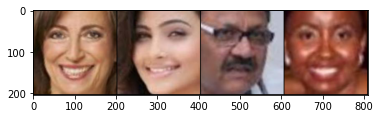

Age:    52 Age:    26 Age:    56 Age:    36
Sex:   1.0 Sex:   1.0 Sex:   0.0 Sex:   1.0


In [4]:
def imshow(img):
    npimg = img.numpy()
    # (RGB, x, y) -> (x, y, RGB)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get some random training images
# Calls trainloader which grabs 4 images (same size as batch_size)
img_path = '/content/UTKFace'
trainloader, testloader = load_dataset(img_path)

dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
imshow(torchvision.utils.make_grid(images))
# print labels
age_labels = [age*116 for age in labels[0]]
print(' '.join('Age: %5s' % int(j.item()) for j in age_labels))
print(' '.join('Sex: %5s' % labels[1][j].numpy() for j in range(4)))


# The base network
The network is based on [ResNet-18](https://arxiv.org/pdf/1512.03385.pdf):

<br>
<div>
<center>
<img src="https://github.com/pedrob37/AML-Lecture-Materials/blob/master/AML_images/ResNet18.png?raw=true" width="300"/>
</center>
</div>

A few changes have been made (due to the limited resources available in this session) that will still allow for the network to make good predictions in a reasonable period of time.

### The Residual Block
ResNet-18 consists of a few residual blocks: Two sequential convolutions that downsample the features followed by a concatenation of the downsampled original features:

<br>
<div>
<center>
<img src="https://github.com/pedrob37/AML-Lecture-Materials/blob/master/AML_images/ResBlock.png?raw=true" width="500"/>
</center>
</div>

While not strictly necessary, it is advantageous for clarity reasons to have the residual blocks be instances of a separate class. Similarly, because we make frequent use of both 3x3 and 1x1 convolutions it is worth creating functions for these as illustrated below:

In [5]:
def conv3x3(in_channels, out_channels, stride=1, dilation=1, padding=1):
    """3x3 convolution: Supports padding"""
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, padding=padding,
                     kernel_size=3, stride=stride, dilation=dilation)
def conv1x1(in_channels, out_channels, stride=1):
    """1x1 convolution: Supports padding"""
    return nn.Conv2d(in_channels=in_channels, out_channels=out_channels, padding=0,
                     kernel_size=1, stride=stride)
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, norm_layer=None, downsample_flag=True):
        super(ResBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(in_channels=in_channels, out_channels=out_channels, stride=stride)
        self.bn1 = norm_layer(out_channels)
        # Don't want to reduce dimensionality further in second conv, hence stride 1
        self.conv2 = conv3x3(in_channels=out_channels, out_channels=out_channels, stride=1)
        self.bn2 = norm_layer(out_channels)
        self.downsample_flag = downsample_flag
        if downsample_flag is not None:
            self.downsample = nn.Sequential(
                conv1x1(in_channels, out_channels, stride),
                norm_layer(out_channels),
            )
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample_flag is not None:
            # Need to downsample x due to shape incompatibility after convolutions if stride > 1
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

Having created our ResBlock we can move onto the network, which simply consists of a series of ResBlocks followed by some fully connected layers.

In [6]:
# Network design
class ResNet(nn.Module):
    def __init__(self, block, first_output_channels=64, norm_layer=None):
        # Initialises the parent class: nn.module
        super(Net, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.first_output_channels = first_output_channels

        self.conv1 = nn.Conv2d(3, self.first_output_channels, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.first_output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = block(self.first_output_channels, self.first_output_channels, stride=1)
        self.layer2 = block(self.first_output_channels, self.first_output_channels*2, stride=2)
        self.layer3 = block(self.first_output_channels*2, self.first_output_channels*4, stride=2)
        self.layer4 = block(self.first_output_channels*4, self.first_output_channels*8, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, image):
        x = self.conv1(image)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ResBlocks
        x = self.layer1.forward(x)
        x = self.layer2.forward(x)
        x = self.layer3.forward(x)
        x = self.layer4.forward(x)

        x = self.avgpool(x)
        # In preparation to pass through a fully connected layer, flatten all features into 1D
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


# Task: Modify the network to allow for multi-task
Having shown that the network works for a single task, it is now time for you to make some modifications to allow for multi-task to be supported. In this case I would like you to modify the network so that in addition to age regression a sex prediction is also made. While there are many valid multi-task architectures you could opt for, for consistency I would like each task-specific branch to have one ResBlock, and the shared layers to have two.

Our total loss will be:

$\mathcal{L}_{total} = \mathcal{L}_{age} + \lambda \mathcal{L}_{sex}$

where $\mathcal{L}_{age}$ is the L1 loss (see Losses lecture) and $\mathcal{L}_{sex}$ is the binary cross-entropy (see Losses lecture). The $\lambda$ determines the relative contribution of each task to the total loss.

Remember that for most multi-task networks the first few layers will be shared and the final few will be task-specific. Also be careful about choosing the output size, consider the task at hand.

In [7]:
class MultiNet(nn.Module):
    def __init__(self, block, first_output_channels=128, num_classes=2, norm_layer=None):
        # Initialises the parent class: nn.module
        super(MultiNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.first_output_channels = first_output_channels
        # Should create a BasicBlock class due to structure similarity but parameter differences
        self.conv1 = nn.Conv2d(3, self.first_output_channels, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.first_output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = block(self.first_output_channels, self.first_output_channels, stride=1)
        self.layer2 = block(self.first_output_channels, self.first_output_channels * 2, stride=2)
        self.layer3 = block(self.first_output_channels * 2, self.first_output_channels * 4, stride=2)
        self.layer4 = block(self.first_output_channels * 4, self.first_output_channels * 8, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1_x = nn.Linear(self.first_output_channels * 4, 100)
        self.fc2_x = nn.Linear(100, 20)
        self.fc3_x = nn.Linear(20, 1)

        self.fc1_y = nn.Linear(self.first_output_channels * 4, 100)
        self.fc2_y = nn.Linear(100, 20)
        # Have to create a separate fully connected layer for the second task since it is a classification
        self.fc3_y = nn.Linear(20, num_classes)
    def forward(self, image):
        shared_xy = self.conv1(image)
        shared_xy = self.bn1(shared_xy)
        shared_xy = self.relu(shared_xy)
        shared_xy = self.maxpool(shared_xy)
        shared_xy = self.layer1.forward(shared_xy)
        shared_xy = self.layer2.forward(shared_xy)
        shared_xy = self.layer3.forward(shared_xy)
        shared_xy = self.avgpool(shared_xy)
        shared_xy = torch.flatten(shared_xy, 1)

        # Task 1 specific layers: Regression as before
        x = self.fc1_x(shared_xy)
        x = self.fc2_x(x)
        x = self.fc3_x(x)

        # Task 2: Classification
        y = self.fc1_y(shared_xy)
        y = self.fc2_y(y)
        y = self.fc3_y(y)
        return x, y


# Network evaluation
Now that you've modified the network, let's see how well it trains:

Epoch: 1, Iteration: 50, Total Loss: 1.004, Task1 Loss: 0.240, Task2 Loss: 0.764
Epoch: 1, Iteration: 100, Total Loss: 0.864, Task1 Loss: 0.173, Task2 Loss: 0.690
Epoch: 1, Iteration: 150, Total Loss: 0.879, Task1 Loss: 0.184, Task2 Loss: 0.695
Epoch: 1, Iteration: 200, Total Loss: 0.867, Task1 Loss: 0.171, Task2 Loss: 0.697
Epoch: 1, Iteration: 250, Total Loss: 0.818, Task1 Loss: 0.155, Task2 Loss: 0.663
Epoch: 1, Iteration: 300, Total Loss: 0.853, Task1 Loss: 0.170, Task2 Loss: 0.683
Epoch: 1, Iteration: 350, Total Loss: 0.858, Task1 Loss: 0.177, Task2 Loss: 0.680
Epoch: 1, Iteration: 400, Total Loss: 0.833, Task1 Loss: 0.159, Task2 Loss: 0.673
Epoch: 1, Iteration: 450, Total Loss: 0.841, Task1 Loss: 0.173, Task2 Loss: 0.668
Epoch: 1, Iteration: 500, Total Loss: 0.781, Task1 Loss: 0.143, Task2 Loss: 0.638
Epoch: 1, Iteration: 550, Total Loss: 0.797, Task1 Loss: 0.155, Task2 Loss: 0.642
Epoch: 1, Iteration: 600, Total Loss: 0.850, Task1 Loss: 0.174, Task2 Loss: 0.676
Epoch: 1, Iterati

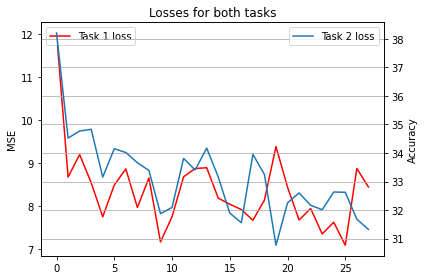

In [8]:
# Model training
# Create network instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
multi_resnet = MultiNet(ResBlock)
multi_resnet.cuda(device)
number_of_epochs = 2

# Define a loss and optimiser
task1_criterion = nn.MSELoss()
# Cross entropy is used because this is a classification task
task2_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(multi_resnet.parameters(), lr=0.001)

# Train the network
task1_loss_array_stag = []
task2_loss_array_stag = []
loss_array = []
for epoch in range(number_of_epochs):
    running_loss = 0
    task1_running_loss = 0
    task2_running_loss = 0
    for iteration, data in enumerate(trainloader):
        inputs, full_labels = data
        if inputs is None or full_labels is None:
          continue
        age_labels = full_labels[0]
        sex_labels = full_labels[1]
        inputs = inputs.to(device, dtype=torch.float)
        age_labels = age_labels.to(device, dtype=torch.float)
        sex_labels = sex_labels.to(device, dtype=torch.long)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        age_regression, sex_classification = multi_resnet(inputs)

        # Calculate loss
        task1_loss = task1_criterion(age_regression.squeeze(), age_labels) ** 0.5
        task2_loss = task2_criterion(sex_classification.squeeze(), sex_labels)
        total_loss = task1_loss + task2_loss

        # Back-propagation of gradients
        total_loss.backward()

        # Optimize
        optimizer.step()

        # Print statistics
        loss_array.append(total_loss)
        running_loss += total_loss.item()
        task1_running_loss += task1_loss.item()
        task2_running_loss += task2_loss.item()
        if iteration % 50 == 49:  # Print every 50 mini-batches, weird choice of numbers to exclude zero
            print('Epoch: {:.0f}, Iteration: {:.0f}, Total Loss: {:.3f}, '
                  'Task1 Loss: {:.3f}, '
                  'Task2 Loss: {:.3f}'.format(epoch + 1, iteration + 1,
                                              running_loss / 50,
                                              task1_running_loss / 50,
                                              task2_running_loss / 50))
            task1_loss_array_stag.append(task1_running_loss)
            task2_loss_array_stag.append(task2_running_loss)
            task1_running_loss = 0
            task2_running_loss = 0
            running_loss = 0

print('Finished Training')
fig, ax1 = plt.subplots()
ax1.plot(list(range(len(task1_loss_array_stag))), [loss_arr for loss_arr in task1_loss_array_stag], label='Task 1 loss', c='r')
ax1.set_ylabel('MSE')
ax2 = ax1.twinx()
ax2.plot(list(range(len(task2_loss_array_stag))), [loss_arr for loss_arr in task2_loss_array_stag], label='Task 2 loss')
ax2.set_ylabel('Accuracy')
plt.title('Losses for both tasks')
plt.xlabel('Iterations')
ax1.legend(loc='upper left')
ax2.legend(loc='best')
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Let's evaluate the network's performance on both tasks across all of the test images:

In [9]:
def evaluate_model(model, testloader):
  print('EVALUATION')
  total_correct = 0
  task1_correct = 0
  task2_correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          labels = torch.stack(labels)
          images = images.to(device)
          labels = labels.to(device)
          # Note: Will NOT get warning if outputs and labels different sizes! e.g.: [4, 1] and [4]
          #       When carrying out operations (e.g.: subtraction) will end up with [4, 4]: Lesson: Squeeze!
          age_regression, sex_classification = model(images)
          # _, predicted = torch.max(outputs.data, 1)
          total += images.size(0)
          task1_correct += task1_criterion(torch.squeeze(age_regression), labels[0].float()).sum().item()
          task2_correct += (torch.max(sex_classification, 1)[1] == labels[1].long()).sum().item()
          total_correct = task1_correct + task2_correct
  # print('Total Accuracy of the network on the test images: {}'.format(total_correct / total))
  print('Task 1 (Age) MSE of the network on the test images: {}'.format((task1_correct / total * 116.0)**0.5))
  print('Task 2 (Sex) accuracy of the network on the test images: {}'.format(task2_correct / total))
evaluate_model(multi_resnet, testloader)

EVALUATION
Task 1 (Age) MSE of the network on the test images: 0.895068314120349
Task 2 (Sex) accuracy of the network on the test images: 0.592944369063772


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


We've trained our network and evaluated it. Note down these numbers and repeat the training with a different choice of lambda. Try $\lambda = 10$ and $\lambda = 0.1$ . How do you expect the performance on Task 1 and Task 2 to differ? Try and find the value of $\lambda$ which maximises performance across both tasks.

... though it seems like Task 2 did not perform much better than random chance. We will look at techniques to help out in this in the exercises to follow.

# Gradient Normalisation
One of the techniques used to address task dominance imbalances is gradient normalisation, or GradNorm. In GradNorm the weights used to modulate the task losses are learnable parameters themselves that are adjusted according to the relative size of the gradients that each of the tasks propagates.  

<br>
<div>
<center>
<img src="https://github.com/pedrob37/AML-Lecture-Materials/blob/master/AML_images/GradNorm.png?raw=true" width="800"/>
</center>
</div>

The standard training loop is provided:

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch: 1, Iteration: 50, Total Loss: 1.044, Task1 Loss: 0.310, Task2 Loss: 0.734
Rates 1 and 2: [1.129] [0.871]
Epoch: 1, Iteration: 100, Total Loss: 0.853, Task1 Loss: 0.161, Task2 Loss: 0.692
Rates 1 and 2: [1.225] [0.775]
Epoch: 1, Iteration: 150, Total Loss: 0.831, Task1 Loss: 0.154, Task2 Loss: 0.677
Rates 1 and 2: [0.828] [1.172]
Epoch: 1, Iteration: 200, Total Loss: 0.861, Task1 Loss: 0.175, Task2 Loss: 0.686
Rates 1 and 2: [0.939] [1.061]
Epoch: 1, Iteration: 250, Total Loss: 0.843, Task1 Loss: 0.156, Task2 Loss: 0.686
Rates 1 and 2: [1.326] [0.674]
Epoch: 1, Iteration: 300, Total Loss: 0.829, Task1 Loss: 0.158, Task2 Loss: 0.671
Rates 1 and 2: [0.982] [1.018]
Epoch: 1, Iteration: 350, Total Loss: 0.834, Task1 Loss: 0.163, Task2 Loss: 0.671
Rates 1 and 2: [1.086] [0.914]
Epoch: 1, Iteration: 400, Total Loss: 0.845, Task1 Loss: 0.179, Task2 Loss: 0.667
Rates 1 and 2: [0.931] [1.069]
Epoch: 1, Iteration: 450, Total Loss: 0.844, Task1 Loss: 0.166, Task2 Loss: 0.679
Rates 1 and 2: 

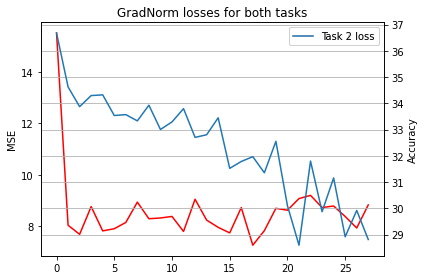

EVALUATION
Task 1 (Age) MSE of the network on the test images: 0.9097048359545893
Task 2 (Sex) accuracy of the network on the test images: 0.5902306648575305


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [10]:
multi_resnet = MultiNet(ResBlock)
multi_resnet.cuda(device)

# Initialise the loss weight parameters
w1 = torch.FloatTensor([1]).to(device).detach().requires_grad_(True)
w2 = torch.FloatTensor([1]).to(device).detach().requires_grad_(True)
params = [w1, w2]
scaling = w1 + w2

# GradLoss
GradLoss = nn.L1Loss()

# Optimisations
opt1 = torch.optim.Adam(multi_resnet.parameters(), lr=0.001)
opt2 = torch.optim.Adam(params, lr=0.0005)

# Rate initialisation
rate_1 = 1
rate_2 = 1
alpha = 0.5

# Train the network
loss_array = []
loss_array_stag = []
task1_loss_array_stag = []
task2_loss_array_stag = []
shared_params = [p[1] for p in multi_resnet.named_parameters() if 'fc' not in p[0] and 'downsample' not in p[0]]
for epoch in range(number_of_epochs):
    running_loss = 0
    task1_running_loss = 0
    task2_running_loss = 0
    for iteration, data in enumerate(trainloader):
        inputs, full_labels = data
        age_labels = full_labels[0]
        sex_labels = full_labels[1]
        inputs = inputs.to(device, dtype=torch.float)
        age_labels = age_labels.to(device, dtype=torch.float)
        sex_labels = sex_labels.to(device, dtype=torch.long)

        # Forward pass
        age_regression, sex_classification = multi_resnet(inputs)

        # Losses
        L1_t = torch.mul(params[0], task1_criterion(age_regression.squeeze(), age_labels) ** 0.5)
        L2_t = torch.mul(params[1], task2_criterion(sex_classification.squeeze(), sex_labels))
        total_loss = torch.add(L1_t, L2_t)

        # Relative losses
        if iteration == 0:
            # Calculate loss (Internally post-processes output to be directly comparable to labels)
            L1_0 = L1_t.detach()
            L2_0 = L2_t.detach()

        opt1.zero_grad()
        # Back-propagation of gradients
        total_loss.backward(retain_graph=True)

        Lhat_1 = torch.div(L1_t, L1_0)
        Lhat_2 = torch.div(L2_t, L2_0)
        Lhat_avg = torch.div(torch.add(Lhat_1, Lhat_2), 2)
        rate_1 = torch.div(Lhat_1, Lhat_avg)
        rate_2 = torch.div(Lhat_2, Lhat_avg)

        # Relative gradients: Only for FINAL (shared) layer
        G1 = torch.autograd.grad(L1_t, shared_params, retain_graph=True, create_graph=True, allow_unused=True)[0]
        G1_norm = torch.norm(G1, 2)
        G2 = torch.autograd.grad(L2_t, shared_params, retain_graph=True, create_graph=True, allow_unused=True)[0]
        G2_norm = torch.norm(G2, 2)
        G_avg = torch.div(torch.add(G1_norm, G2_norm), 2)

        # Gradient losses
        G1_des = G_avg * rate_1 ** alpha
        G2_des = G_avg * rate_2 ** alpha
        L1_G = GradLoss(G1_norm, G1_des.detach())
        L2_G = GradLoss(G2_norm, G2_des.detach())

        opt2.zero_grad()
        # Updates
        L_G_avg = torch.div(torch.add(L1_G, L2_G), 2)
        L_G_avg.backward()
        # Don't forget update steps here
        opt1.step()
        opt2.step()
        # print(params)

        # Renormalisation
        # with torch.no_grad():
        # This did NOT work with stack for some reason: torch.mean(torch.stack(params))
        # print('w1 and w2 are {} and {}'.format(w1, w2))
        renorm = torch.div(torch.add(w1, w2), scaling)
        params = [torch.div(w1, renorm), torch.div(w2, renorm)]

        # Print statistics
        # loss_array.append(total_loss)
        running_loss += total_loss.item()
        task1_running_loss += L1_t.item()
        task2_running_loss += L2_t.item()
        if iteration % 50 == 49:  # Print every 500 mini-batches, weird choice of numbers to exclude zero
            print('Epoch: {:.0f}, Iteration: {:.0f}, Total Loss: {:.3f}, '
                  'Task1 Loss: {:.3f}, '
                  'Task2 Loss: {:.3f}'.format(epoch + 1, iteration + 1,
                                              running_loss / 50,
                                              task1_running_loss / 50,
                                              task2_running_loss / 50))
            # print('Parameters are currently: {}'.format([param.item() for param in params]))
            print('Rates 1 and 2: [{:.3f}] [{:.3f}]'.format(rate_1.cpu().detach().numpy()[0], rate_2.cpu().detach().numpy()[0]))
            loss_array_stag.append(running_loss)
            task1_loss_array_stag.append(task1_running_loss)
            task2_loss_array_stag.append(task2_running_loss)
            running_loss = 0
            task1_running_loss = 0
            task2_running_loss = 0

print('Finished Training')
fig, ax1 = plt.subplots()
# Loss array stag: Running loss for every 500 iterations
# loss_arr.cpu().detach().numpy(): Don't need to do this if call loss.item()
# ax1.plot(list(range(len(loss_array_stag))), [loss_arr for loss_arr in loss_array_stag])
ax1.plot(list(range(len(task1_loss_array_stag))), [loss_arr for loss_arr in task1_loss_array_stag], label='Task 1 loss', c='r')
ax1.set_ylabel('MSE')
ax2 = ax1.twinx()
ax2.plot(list(range(len(task2_loss_array_stag))), [loss_arr for loss_arr in task2_loss_array_stag], label='Task 2 loss')
ax2.set_ylabel('Accuracy')
plt.title('GradNorm losses for both tasks')
plt.xlabel('Iterations')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

evaluate_model(multi_resnet, testloader)

# Gradient cosine similarity
We'll tackle using cosine similarity to modulate auxiliary gradients next. Remember that with auxiliary tasks we are not concerned with their optimisation, we only hope that their inclusion in the network can aid in increasing the feature richness and robustness only insofar as they benefit the main task. One of the ways in which this can be accomplished is by comparing the gradients being propagated by each task. Since we want the auxiliary task to aid the main we do not want its gradient to cancel out its counterpart's. Calculating the cosine similarity tells us exactly this, a negative outcome signals pathological behaviour (The angle subtended between the gradients is greater than 90 degrees) while a positive outcome suggests cooperation (The angle subtended between the gradients is smaller than 90 degrees). 

![alt text](https://github.com/pedrob37/AML_Lecture4/blob/master/AML_images/unweighted_cosine.png?raw=true)

<br>
<div>
<center>
<img src="https://github.com/pedrob37/AML-Lecture-Materials/blob/master/AML_images/CosSimilarity.png?raw=true" width="1000"/>
</center>
</div>

I would like you to implement both unweighted and weighted gradient cosine similarities. As a reminder, the unweighted version simply zeros any pathological gradients while fully keeping potentially beneficial ones, while the weighted version scales the beneficial ones according to the cosine similarity. You should begin by writing a function that computes the cosine similarity between two gradients. Having done so you should modify the training loop to include the cosine gradient similarity calculation, and to propagate the result according to its value. Remember that the gradient modification should only affect the shared layers, so you should aim to find the ID for the final shared weights layer. The standard training loop has been provided:  
  
**Hint**: Consider following these steps:  
1. Calculate the gradients of each task separately for only the shared layers, use the [torch.autograd.grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad) method for this
2. Calculate the gradient similarity between these gradients
3. Write an if statement conditioned on the outcome of the cosine similarity.

Epoch: 1, Iteration: 50, Task1 Loss: 0.205, Task2 Loss: 0.000 CosSim: -0.449
Epoch: 1, Iteration: 100, Task1 Loss: 0.229, Task2 Loss: 0.000 CosSim: 0.682
Epoch: 1, Iteration: 150, Task1 Loss: 0.293, Task2 Loss: 0.000 CosSim: -0.281
Epoch: 1, Iteration: 200, Task1 Loss: 0.291, Task2 Loss: 0.000 CosSim: 0.070
Epoch: 1, Iteration: 250, Task1 Loss: 0.270, Task2 Loss: 0.001 CosSim: -0.007
Epoch: 1, Iteration: 300, Task1 Loss: 0.239, Task2 Loss: 0.000 CosSim: 0.343
Epoch: 1, Iteration: 350, Task1 Loss: 0.173, Task2 Loss: 0.000 CosSim: 0.084
Epoch: 1, Iteration: 400, Task1 Loss: 0.190, Task2 Loss: 0.000 CosSim: -0.197
Epoch: 1, Iteration: 450, Task1 Loss: 0.153, Task2 Loss: 0.000 CosSim: -0.458
Epoch: 1, Iteration: 500, Task1 Loss: 0.144, Task2 Loss: 0.000 CosSim: -0.598
Epoch: 1, Iteration: 550, Task1 Loss: 0.128, Task2 Loss: 0.000 CosSim: -0.889
Epoch: 1, Iteration: 600, Task1 Loss: 0.202, Task2 Loss: 0.000 CosSim: -0.370
Epoch: 1, Iteration: 650, Task1 Loss: 0.287, Task2 Loss: 0.000 CosSim

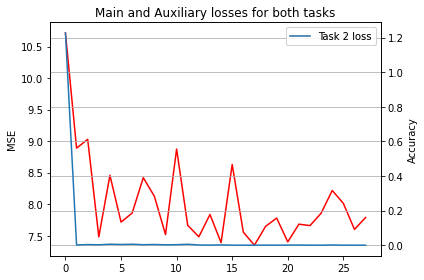

EVALUATION
Task 1 (Age) MSE of the network on the test images: 0.8265676358029627
Task 2 (Sex) accuracy of the network on the test images: 0.5264586160108549
Cos similarity overall: 9.998462677001953


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [13]:
cos_mode = 'weighted'  # set to 'unweighted' or 'weighted'

def cos_similarity_calc(grad1, grad2):
    cos_operation = nn.CosineSimilarity(dim=0)
    flat_grad1 = torch.cat([grad.flatten() for grad in grad1], dim=-1)
    flat_grad2 = torch.cat([grad.flatten() for grad in grad2], dim=-1)
    return cos_operation(flat_grad1, flat_grad2)

# Initialise network instance
multi_resnet = MultiNet(ResBlock)
multi_resnet.cuda(device)

# Define a loss and optimiser
task1_criterion = nn.MSELoss()

# Cross entropy is used because this is a classification task
aux_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(multi_resnet.parameters(), lr=0.001)

# Train the network
task1_loss_array_stag = []
aux_loss_array_stag = []
cos_similarity_array = []
shared_params = [p[1] for p in multi_resnet.named_parameters() if 'fc' not in p[0] and 'downsample' not in p[0]]
for epoch in range(number_of_epochs):
    task1_running_loss = 0
    aux_running_loss = 0
    for iteration, data in enumerate(trainloader):
        inputs, full_labels = data
        age_labels = full_labels[0]
        # sex_labels = full_labels[1]
        sex_labels = torch.rand(age_labels.size())
        inputs = inputs.to(device, dtype=torch.float)
        age_labels = age_labels.to(device, dtype=torch.float)
        sex_labels = sex_labels.to(device, dtype=torch.long)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        age_regression, sex_classification = multi_resnet(inputs)

        # Calculate loss
        task1_loss = task1_criterion(age_regression.squeeze(), age_labels) ** 0.5
        aux_loss = aux_criterion(sex_classification.squeeze(), sex_labels)
        
        # Calculate the gradients with respect to the SHARED layers for each task:
        # The torch.autograd.grad method allows you to calculate the gradients with respect to a
        # subset of parameters
        G_main_shared = torch.autograd.grad(task1_loss, shared_params,
                              retain_graph=True, create_graph=True, allow_unused=True)
        G_aux_shared = torch.autograd.grad(aux_loss, shared_params,
                                    retain_graph=True, create_graph=True, allow_unused=True)
        G_main_shared = [grad for grad in G_main_shared if grad is not None]
        G_aux_shared = [grad for grad in G_aux_shared if grad is not None]
        # Calculate the cosine similarity
        cos_similarity = cos_similarity_calc(G_main_shared, G_aux_shared)
        aux_loss.backward(retain_graph=True)
        # Modify the gradients according to the mode
        if cos_mode == 'weighted':
            # If cosine sim. is -ve don't want the auxiliary gradients to be propagated through the shared layers
            # Therefore zero the auxiliary gradients in the shared layers
            if cos_similarity < 0:
                # We drop the auxiliary
                for layer in shared_params:
                  if layer.grad is None:
                      continue
                  else:
                      layer.grad *= 0
            else:
                # In this instance, if the cosine similarity is positive we still want to scale it by the value
                for layer in shared_params:
                    if layer.grad is None:
                      continue
                    layer.grad *= cos_similarity
        
        elif cos_mode == 'unweighted':
            if cos_similarity < 0:
                # This would be exactly the same as before
                for layer in shared_params:
                    if layer.grad is None:
                      continue
                    else:
                      layer.grad *= 0
        task1_loss.backward()
        optimizer.step()
        task1_running_loss += task1_loss.item()
        # Keeping a track of this only for curiosity's sake since we aren't optimising directly for it
        aux_running_loss += aux_loss.item()
        cos_similarity_array.append(cos_similarity.detach().cpu())
        if iteration % 50 == 49:  # Print every 50 mini-batches, weird choice of numbers to exclude zero
            print('Epoch: {:.0f}, Iteration: {:.0f}, '
                  'Task1 Loss: {:.3f}, '
                  'Task2 Loss: {:.3f}'.format(epoch + 1, iteration + 1,
                                              task1_loss.item(),
                                              aux_loss.item()), 
                  'CosSim: {:.3f}'.format(cos_similarity))
            task1_loss_array_stag.append(task1_running_loss)
            aux_loss_array_stag.append(aux_running_loss)
            task1_running_loss = 0
            aux_running_loss = 0

fig, ax1 = plt.subplots()
# Loss array stag: Running loss for every 500 iterations
# loss_arr.cpu().detach().numpy(): Don't need to do this if call loss.item()
# ax1.plot(list(range(len(loss_array_stag))), [loss_arr for loss_arr in loss_array_stag])
ax1.plot(list(range(len(task1_loss_array_stag))), [loss_arr for loss_arr in task1_loss_array_stag], label='Task 1 loss', c='r')
ax1.set_ylabel('MSE')
ax2 = ax1.twinx()
ax2.plot(list(range(len(aux_loss_array_stag))), [loss_arr for loss_arr in aux_loss_array_stag], label='Task 2 loss')
ax2.set_ylabel('Accuracy')
plt.title('Main and Auxiliary losses for both tasks')
plt.xlabel('Iterations')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.grid()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

evaluate_model(multi_resnet, testloader)
print('Cos similarity overall: {}'.format(np.sum(np.array(cos_similarity_array))))

# What about Multi-input training?

So far we've covered learning multiple tasks from a single image. But what if we have access to other information which might make the task easier? Do you think you would find it easier to predict sex if you had an image and the age of the person? Maybe, maybe not. We're going to see how we can feed these multimodal inputs to a convolutional neural network despite the big differences in their sizes.

The images that we're using are of size 3 x 200 x 200. We've chosen a convolutional neural network to extract features from that image. Age is a single scalar value. We don't need a feature extractor applied to it as it is already a feature.

In order to incorporate age we can simply concatenate it to the flattened fully connected layer at the end of our ResNet. 

Try concatenating the age onto that feature vector in the code below and see whether you can improve on the sex classification task.



In [14]:
# Network design
class MultiInputResNet(nn.Module):
    def __init__(self, block, first_output_channels=64, norm_layer=None):
        # Initialises the parent class: nn.module
        super(MultiInputResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.first_output_channels = first_output_channels

        self.conv1 = nn.Conv2d(3, self.first_output_channels, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.first_output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = block(self.first_output_channels, self.first_output_channels, stride=1)
        self.layer2 = block(self.first_output_channels, self.first_output_channels*2, stride=2)
        self.layer3 = block(self.first_output_channels*2, self.first_output_channels*4, stride=2)
        self.layer4 = block(self.first_output_channels*4, self.first_output_channels*8, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 100)
        # This linear layer needs to be changed to size 101
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(21, 2)

    def forward(self, image, age):
        x = self.conv1(image)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # ResBlocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # In preparation to pass through a fully connected layer, flatten all features into 1D
        x = nn.Flatten()(x) # torch.flatten(x, 1)
        x = self.fc1(x)
        # TODO: Concatenate the age here.
        x = self.fc2(x)
        x = torch.cat([x, torch.unsqueeze(age, 1)], axis=1)
        x = self.fc3(x)
        return x

1 50, Total Loss: 0.740
1 100, Total Loss: 0.699
1 150, Total Loss: 0.684
1 200, Total Loss: 0.635
1 250, Total Loss: 0.671
1 300, Total Loss: 0.700
1 350, Total Loss: 0.675
1 400, Total Loss: 0.640
1 450, Total Loss: 0.651
1 500, Total Loss: 0.665
1 550, Total Loss: 0.665
1 600, Total Loss: 0.671
1 650, Total Loss: 0.639
1 700, Total Loss: 0.640
2 50, Total Loss: 0.620
2 100, Total Loss: 0.653
2 150, Total Loss: 0.620
2 200, Total Loss: 0.615
2 250, Total Loss: 0.614
2 300, Total Loss: 0.684
2 350, Total Loss: 0.636
2 400, Total Loss: 0.590
2 450, Total Loss: 0.665
2 500, Total Loss: 0.645
2 550, Total Loss: 0.607
2 600, Total Loss: 0.620
2 650, Total Loss: 0.550
2 700, Total Loss: 0.608
3 50, Total Loss: 0.635
3 100, Total Loss: 0.572
3 150, Total Loss: 0.610
3 200, Total Loss: 0.580
3 250, Total Loss: 0.595
3 300, Total Loss: 0.563
3 350, Total Loss: 0.544
3 400, Total Loss: 0.539
3 450, Total Loss: 0.545
3 500, Total Loss: 0.523
3 550, Total Loss: 0.582
3 600, Total Loss: 0.578
3 6

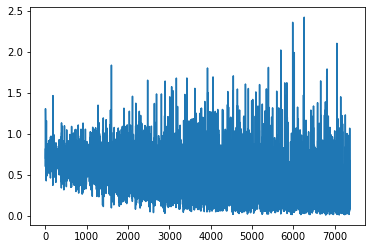

In [15]:
# Model training
# Create network instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MultiInputResNet(ResBlock)
model.cuda(device)

# Define a loss and optimiser
# Cross entropy is used because this is a classification task
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the network
loss_array = []
for epoch in range(10):
    running_loss = 0
    for iteration, data in enumerate(trainloader):
        inputs, full_labels = data
        if inputs is None or full_labels is None:
          continue
        age_labels = full_labels[0]
        sex_labels = full_labels[1]
        inputs = inputs.to(device, dtype=torch.float)
        age_labels = age_labels.to(device, dtype=torch.float)
        sex_labels = sex_labels.to(device, dtype=torch.long)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        sex_classification = model(inputs, age_labels)

        # Calculate loss
        total_loss = criterion(sex_classification.squeeze(), sex_labels)

        # Back-propagation of gradients
        total_loss.backward()

        # Optimize
        optimizer.step()

        # Print statistics
        loss_array.append(total_loss)
        running_loss += total_loss.item()
        if iteration % 50 == 49:  # Print every 50 mini-batches, weird choice of numbers to exclude zero
            print('{:.0f} {:.0f}, Total Loss: {:.3f}'.format(
                epoch + 1, iteration + 1, running_loss / 50))
            running_loss = 0

print('Finished Training')
plt.figure()
# Loss array stag: Running loss for every 50 iterations
plt.plot(list(range(len(loss_array))), [loss_arr for loss_arr in loss_array])
plt.show()

In [16]:
def evaluate_model(model, testloader):
  print('EVALUATION')
  total_correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          label_set = set(labels[0].cpu().detach().numpy())
          labels = torch.stack(labels)
          images = images.to(device)
          labels = labels.to(device)
          # Note: Will NOT get warning if outputs and labels different sizes! e.g.: [4, 1] and [4]
          #       When carrying out operations (e.g.: subtraction) will end up with [4, 4]: Lesson: Squeeze!
          sex_classification = model(images, labels[0].type(torch.FloatTensor).to(device))
          # _, predicted = torch.max(outputs.data, 1)
          total += images.size(0)
          total_correct += (torch.max(sex_classification, 1)[1] == labels[1].long()).sum().item()
  print('Sex accuracy of the network on the test images: {}'.format(total_correct / total))

evaluate_model(model, testloader)


EVALUATION
Sex accuracy of the network on the test images: 0.8385345997286295


# Does our network even use Age as a feature?

Our CNN can be thought of as a feature extractor. If we look at the penultimate layer, `fc2`, we get a 20 dimensional vector which describes the image. In the section below we'll use our trained model as a feature extractor and try and understand if age is a useful feature for sex classification.





In [17]:
# Get the average activation vectors across the test set for each of the 20 image features in the penultimate layer + the age feature to normalise the weights and biases
batch_iter = 0
sexes = []
features = []
with torch.no_grad():
      for data in testloader:
          images, labels = data
          labels = torch.stack(labels)
          images = images.to(device)
          labels = labels.to(device)
          # Loop through each image batch in the test set and extract the activation
          feature_extractor = nn.Sequential(*[
                                             model.conv1,
                                             model.bn1,
                                             model.relu,
                                             model.maxpool,
                                             model.layer1,
                                             model.layer2,
                                             model.layer3,
                                             model.layer4,
                                             model.avgpool,
                                             nn.Flatten(),
                                             model.fc1,
                                             model.fc2])
          # Extract age and sex labels
          age = labels[0].cpu().detach().numpy()
          sexes.append(labels[1].cpu().detach().numpy())
          # Calculate the activations for the current image batch by calling the feature extractor
          image_features = feature_extractor(images).cpu().detach().numpy()
          for i in range(image_features.shape[0]):
              f = np.array(list(image_features[i]) + [age[i]])
              features.append(f)

In [18]:
# Convert our input features and output ground truths into numpy arrays
X = np.array(features)
y = np.concatenate(sexes)
# Let's check the shape of our input and output
print('X shape is: {}, Y shape is: {}'.format(X.shape, y.shape))

X shape is: (737, 21), Y shape is: (737,)


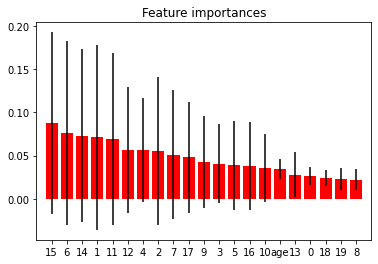

In [19]:
# We will calculate relative feature importance using a random forest classifier
# Reference: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=100)

# Fit the trees to X and y
forest.fit(X, y)

# Calculate the feature importances
importances = forest.feature_importances_

# Calculate the standard deviation across the estimators, for each feature
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

# Sort according to importance (descending)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
xticks = list(indices)
xticks[xticks.index(20)] = 'age'
plt.xticks(range(X.shape[1]), xticks)
plt.xlim([-1, X.shape[1]])
plt.show()
